# How to work with ERA5 single levels on Earth Data Hub
### Modelling of climate zones in Europe

***
This notebook will provide you guidance on how to access and use the `ecv-for-climate-change-1979-2023.zarr` datset on Earth Data Hub (EDH).

The first goal is to compute monthly averages over Europe.

The second goal is model a given number of different climate using a profile classification model.
***

## What you will learn:

* how to access and preview the dataset
* select and reduce the data
* define a profile classification model (PCM)
* plot the results

## Installation of software packages in Google Colab
***

* The zarr package is needed by xarray to use `engine="zarr"` for Earth Data Hub datasets, needs to be installed before xarray is imported
* The s3fs package is needed to access S3


In [ ]:
# install dependencies
# this cell might need to be run twice to solve version conflicts
# can not use the apt package python3-zarr because of too old numcodecs without BitRound compressor
#!apt-get remove -y python3-numcodecs

!pip install zarr
!pip install cartopy
# use latest pyxpcm to avoid incompatibility with new numpy versions
#!pip install pyxpcm
!pip install ipython==8.3.0
!pip install git+https://github.com/obidam/pyxpcm.git@master


Support for S3 filesystem incl. python package

In [ ]:
!apt-get install s3fs

#!pip install fsspec==2023.6.0
!pip uninstall -y s3fs
#!pip uninstall -y gcsfs
#!pip uninstall -y fsspec

# the s3fs version must match the already installed version of gcsfs
!pip install s3fs==2023.6.0


## Load packages needed for this tutorial

In [2]:
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
print("xarray: %s, %s" % (xr.__version__, xr.__file__))

import matplotlib.pyplot as plt
%matplotlib inline

import pyxpcm
print("pyxpcm: %s, %s" % (pyxpcm.__version__, pyxpcm.__file__))

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

xarray: 2023.7.0, /usr/local/lib/python3.10/dist-packages/xarray/__init__.py
pyxpcm: 0.4.1, /usr/local/lib/python3.10/dist-packages/pyxpcm/__init__.py


## Data access and preview
***

Xarray and Dask work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

***

In [ ]:
# your `~/.netrc` file MUST contain your credentials for earthdatahub.com
#
# machine earthdatahub.com
#   login {your_username}
#   password {your_password}

dataset_url = "https://earthdatahub.com/stores/ecmwf-era5-single-levels/reanalysis-era5-single-levels-v0.zarr"
ds = xr.open_dataset(dataset_url, chunks={}, engine="zarr", storage_options={"client_kwargs": {"trust_env": True}})
ds

## Working with data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment.

The structure of a workflow that uses EDH data looks like this:
1. data selection
2. (optional) data reduction
3. (optional) visualization

## Long-term monthly averages of the variables for Europe

### 1. Data selection

We perform a geographical selection corresponding to the central Europe area. This reduces the amount of data that will be downloaded from EDH.

In [4]:
ds_europe = ds.sel(**{"latitude": slice(55, 45), "longitude": slice(2, 24)})
ds_europe

<xarray.Dataset>
Dimensions:     (valid_time: 736344, latitude: 41, longitude: 89)
Coordinates:
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 45.5 45.25 45.0
  * longitude   (longitude) float64 2.0 2.25 2.5 2.75 ... 23.25 23.5 23.75 24.0
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1940-01-01 ... 2023-12-31T23:00:00
Data variables:
    d2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(4320, 41, 56), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(4320, 41, 56), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 dask.array<chunksize=(4320, 41, 56), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(4320, 41, 56), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(4320, 41, 56), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-01-31T19:41 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

### 2. Data reduction

Now we want monthly long-term averages, but only for the last 30 years (the dataset starts at 1940-01-01):

In [5]:
ds_europe_30yrs = ds_europe.sel(valid_time=slice("1991-01-01", "2020-12-31"))
ds_europe_30yrs

<xarray.Dataset>
Dimensions:     (valid_time: 262992, latitude: 41, longitude: 89)
Coordinates:
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 45.5 45.25 45.0
  * longitude   (longitude) float64 2.0 2.25 2.5 2.75 ... 23.25 23.5 23.75 24.0
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1991-01-01 ... 2020-12-31T23:00:00
Data variables:
    d2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2208, 41, 56), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2208, 41, 56), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 dask.array<chunksize=(2208, 41, 56), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2208, 41, 56), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2208, 41, 56), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-01-31T19:41 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

Windspeed is an interesting variable to add to the modelling of climate zones, but it takes some time to calculate wind speed from the u and v components which must happen before any spatial or temporal aggregation. Therefore windspeed is disabled by default,but can be enabled by setting `USE_WINDSPEED` to `True`.

In [6]:
USE_WINDSPEED = False

if USE_WINDSPEED:
  ds_europe_30yrs = ds_europe_30yrs.assign(windspeed=lambda x: np.sqrt(x.u10 * x.u10 + x.v10 * x.v10))


Long-term monthly averages:

In [7]:
ds_europe_lt_monthly = ds_europe_30yrs.groupby("valid_time.month").mean("valid_time")
ds_europe_lt_monthly

<xarray.Dataset>
Dimensions:    (month: 12, latitude: 41, longitude: 89)
Coordinates:
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 45.5 45.25 45.0
  * longitude  (longitude) float64 2.0 2.25 2.5 2.75 ... 23.25 23.5 23.75 24.0
    number     int64 ...
    surface    float64 ...
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    d2m        (month, latitude, longitude) float32 dask.array<chunksize=(1, 41, 56), meta=np.ndarray>
    t2m        (month, latitude, longitude) float32 dask.array<chunksize=(1, 41, 56), meta=np.ndarray>
    tp         (month, latitude, longitude) float32 dask.array<chunksize=(1, 41, 56), meta=np.ndarray>
    u10        (month, latitude, longitude) float32 dask.array<chunksize=(1, 41, 56), meta=np.ndarray>
    v10        (month, latitude, longitude) float32 dask.array<chunksize=(1, 41, 56), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-01-31T19:41 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts



At this point, no data has been downloaded yet, nor loaded in memory. However, the selection is small enough to call `.compute()` on it. This will trigger the download of data from EDH and load it in memory.

We can measure the time it takes, should be about 3minutes without windspeed, about 8 minutes with windspeed:


In [8]:
%%time

ds_europe_lt_monthly = ds_europe_lt_monthly.compute()

CPU times: user 1min 55s, sys: 41.2 s, total: 2min 36s
Wall time: 2min 57s


### 3. Visualization

We can plot the average precipitation for July on a map:

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


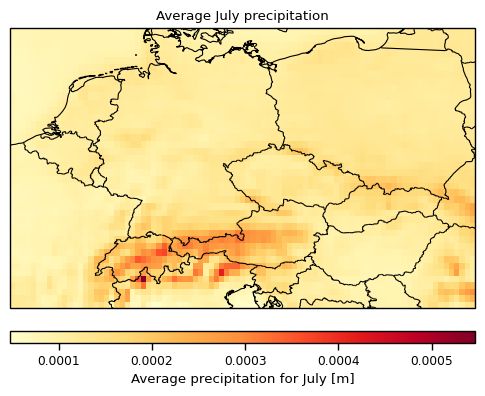

In [9]:
from cartopy import crs, feature
import matplotlib.pyplot as plt

ds_europe_lt_monthly_dec = ds_europe_lt_monthly.sel(month=7)
dec_tp = ds_europe_lt_monthly_dec.tp

_, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={"projection": crs.Miller()},
)
dec_tp.plot(
    ax=ax,
    cmap="YlOrRd",
    transform=crs.PlateCarree(),
    cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "aspect": 40, "label": "Average precipitation for July [m]"},
)
ax.coastlines()
ax.add_feature(feature.BORDERS)
ax.set_title("Average July precipitation")
plt.show()

## Profile Classification Model (PCM)

We want to determine homogeneous climatic zones in Europe using the monthly long-term averages.

### Create a model

Let's import the Profile Classification Model (PCM) constructor:

In [10]:
from pyxpcm.models import pcm

A PCM can be created independently of any dataset using the class constructor.

A PCM requires a number of classes (or clusters) and a dictionary to define the list of features and their profile axis:

In [11]:
z = np.arange(-1, -12, -1)
if USE_WINDSPEED:
  pcm_features = {'temperature': z, 'precipitation':z, 'windspeed': z}
else:
  pcm_features = {'temperature': z, 'precipitation':z}

We can now instantiate a PCM, say with 8 classes:

In [12]:
# error in PCA:
# ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=11 with svd_solver='full'
# n_components is set somewhere internally
# -> try without PCA: reduction=0

m = pcm(K=8, features=pcm_features, reduction=0)
m

<pcm 'gmm' (K: 8, F: 2)>
Number of class: 8
Number of feature: 2
Feature names: odict_keys(['temperature', 'precipitation'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: False, <class 'pyxpcm.utils.NoTransform'>
Feature: 'precipitation'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: False, <class 'pyxpcm.utils.NoTransform'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit the model on data

Fitting can be done on any dataset coherent with the PCM definition, in a sense that it must have the feature variables of the PCM.

To tell the PCM model how to identify features in any :class:`xarray.Dataset`, we need to provide a dictionary of variable names mapping:

In [13]:
if USE_WINDSPEED:
  features_in_ds = {'temperature': 't2m', 'precipitation': 'tp', 'windspeed': 'windspeed'}
else:
  features_in_ds = {'temperature': 't2m', 'precipitation': 'tp'}


which means that the PCM feature ``temperature`` is to be found in the dataset variables ``t2m``.

We also need to specify the profile dimension of the dataset variables:

In [14]:
features_pdim='month'

The values of the profile dimension must be <= 0:

In [15]:
ds_europe_lt_monthly_neg = ds_europe_lt_monthly.assign_coords(month=(-ds_europe_lt_monthly.month))

In [16]:
ds_europe_lt_monthly_neg = ds_europe_lt_monthly_neg.compute()
ds_europe_lt_monthly_neg

<xarray.Dataset>
Dimensions:    (month: 12, latitude: 41, longitude: 89)
Coordinates:
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 45.5 45.25 45.0
  * longitude  (longitude) float64 2.0 2.25 2.5 2.75 ... 23.25 23.5 23.75 24.0
    number     int64 0
    surface    float64 0.0
  * month      (month) int64 -1 -2 -3 -4 -5 -6 -7 -8 -9 -10 -11 -12
Data variables:
    d2m        (month, latitude, longitude) float32 276.1 276.0 ... 270.8 270.7
    t2m        (month, latitude, longitude) float32 279.3 279.3 ... 273.3 273.2
    tp         (month, latitude, longitude) float32 9.891e-05 ... 9.833e-05
    u10        (month, latitude, longitude) float32 3.51 3.496 ... 0.2315
    v10        (month, latitude, longitude) float32 2.319 2.303 ... -0.2631
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-01-31T19:41 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

Now we're ready to fit the model on the this dataset:

In [17]:
m.fit(ds_europe_lt_monthly_neg, features=features_in_ds, dim=features_pdim)
m

<pcm 'gmm' (K: 8, F: 2)>
Number of class: 8
Number of feature: 2
Feature names: odict_keys(['temperature', 'precipitation'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: False, <class 'pyxpcm.utils.NoTransform'>
Feature: 'precipitation'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: False, <class 'pyxpcm.utils.NoTransform'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 25.371660

### Classify data

Now that the PCM is fitted, we can predict the classification results like:

In [18]:
m.predict(ds_europe_lt_monthly_neg, features=features_in_ds, dim=features_pdim, inplace=True)
ds_europe_lt_monthly_neg

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


<xarray.Dataset>
Dimensions:     (month: 12, latitude: 41, longitude: 89)
Coordinates:
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 45.5 45.25 45.0
  * longitude   (longitude) float64 2.0 2.25 2.5 2.75 ... 23.25 23.5 23.75 24.0
    number      int64 0
    surface     float64 0.0
  * month       (month) int64 -1 -2 -3 -4 -5 -6 -7 -8 -9 -10 -11 -12
Data variables:
    d2m         (month, latitude, longitude) float32 276.1 276.0 ... 270.8 270.7
    t2m         (month, latitude, longitude) float32 279.3 279.3 ... 273.3 273.2
    tp          (month, latitude, longitude) float32 9.891e-05 ... 9.833e-05
    u10         (month, latitude, longitude) float32 3.51 3.496 ... 0.2315
    v10         (month, latitude, longitude) float32 2.319 2.303 ... -0.2631
    PCM_LABELS  (latitude, longitude) int64 3 3 3 3 3 3 3 3 ... 7 7 7 7 7 7 7 7
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-01-31T19:41 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

Prediction labels are automatically added to the dataset as `PCM_LABELS` because the option `inplace` was set to `True`.

pyXpcm use a Gaussian Mixture Model (GMM) classifier by default, which is a fuzzy classifier. So we can also predict the probability of each classes for all profiles, the so-called *posteriors*:

In [19]:
m.predict_proba(ds_europe_lt_monthly_neg, features=features_in_ds, dim=features_pdim, inplace=True)
ds_europe_lt_monthly_neg

<xarray.Dataset>
Dimensions:     (month: 12, latitude: 41, longitude: 89, pcm_class: 8)
Coordinates:
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 45.5 45.25 45.0
  * longitude   (longitude) float64 2.0 2.25 2.5 2.75 ... 23.25 23.5 23.75 24.0
    number      int64 0
    surface     float64 0.0
  * month       (month) int64 -1 -2 -3 -4 -5 -6 -7 -8 -9 -10 -11 -12
Dimensions without coordinates: pcm_class
Data variables:
    d2m         (month, latitude, longitude) float32 276.1 276.0 ... 270.8 270.7
    t2m         (month, latitude, longitude) float32 279.3 279.3 ... 273.3 273.2
    tp          (month, latitude, longitude) float32 9.891e-05 ... 9.833e-05
    u10         (month, latitude, longitude) float32 3.51 3.496 ... 0.2315
    v10         (month, latitude, longitude) float32 2.319 2.303 ... -0.2631
    PCM_LABELS  (latitude, longitude) int64 3 3 3 3 3 3 3 3 ... 7 7 7 7 7 7 7 7
    PCM_POST    (pcm_class, latitude, longitude) float64 0.0 0.0 0.0 ... 1.0 1.0
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-01-31T19:41 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

which are added to the dataset as the `PCM_POST` variables. The probability of classes for each profiles has a new dimension `pcm_class` by default that goes from 0 to K-1.

### Geographic distribution of classes

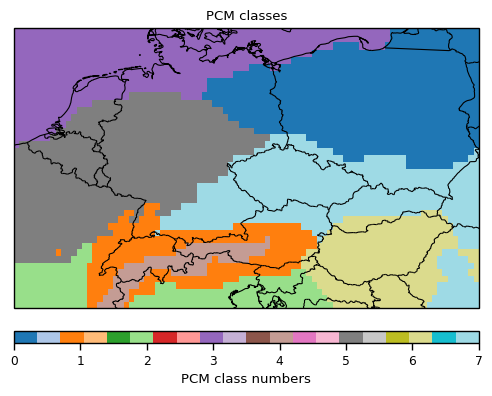

In [21]:
ds_plt = ds_europe_lt_monthly_neg['PCM_LABELS']

_, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={"projection": crs.Miller()},
)
ds_plt.plot(
    ax=ax,
    cmap="tab20",
    transform=crs.PlateCarree(),
    cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "aspect": 40, "label": "PCM class numbers"},
)
ax.coastlines()
ax.add_feature(feature.BORDERS)
ax.set_title("PCM classes")
plt.show()


Show probabilities for a selected class:

In [ ]:
classno = 2
ds_plt = ds_europe_lt_monthly_neg['PCM_POST'].sel(pcm_class=classno)

cmap = sns.light_palette("blue", as_cmap=True)

_, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={"projection": crs.Miller()},
)
ds_plt.plot(
    ax=ax,
    cmap=cmap,
    transform=crs.PlateCarree(),
    cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "aspect": 40, "label": f"Probabilities for class no {classno}"},
)
ax.coastlines()
ax.add_feature(feature.BORDERS)
ax.set_title(f"PCM Probabilities for class no {classno}")
plt.show()

### Prediction

It is important to note that once the PCM is fitted, you can predict labels for any dataset, as long as it has the PCM features.

For instance, let's predict labels for a single year:

In [23]:
ds_europe_2023 = ds_europe.sel(valid_time=slice("2023-01-01", "2023-12-31"))
if USE_WINDSPEED:
  ds_europe_2023 = ds_europe_2023.assign(windspeed=lambda x: np.sqrt(x.u10 * x.u10 + x.v10 * x.v10))


Aggregate to monthly data and prepare for PCM

In [24]:
ds_europe_2023_monthly = ds_europe_2023.groupby("valid_time.month").mean("valid_time")
ds_europe_2023_monthly_neg = ds_europe_2023_monthly.assign_coords(month=(-ds_europe_2023_monthly.month))
ds_europe_2023_monthly_neg = ds_europe_2023_monthly_neg.compute()
ds_europe_2023_monthly_neg

<xarray.Dataset>
Dimensions:    (month: 12, latitude: 41, longitude: 89)
Coordinates:
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 45.5 45.25 45.0
  * longitude  (longitude) float64 2.0 2.25 2.5 2.75 ... 23.25 23.5 23.75 24.0
    number     int64 0
    surface    float64 0.0
  * month      (month) int64 -1 -2 -3 -4 -5 -6 -7 -8 -9 -10 -11 -12
Data variables:
    d2m        (month, latitude, longitude) float32 277.0 277.0 ... 273.2 273.1
    t2m        (month, latitude, longitude) float32 280.2 280.2 ... 276.0 275.9
    tp         (month, latitude, longitude) float32 0.0001179 ... 4.86e-05
    u10        (month, latitude, longitude) float32 6.159 6.134 ... 0.5416 0.844
    v10        (month, latitude, longitude) float32 2.295 2.307 ... -0.4268
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-01-31T19:41 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

Apply the model

In [25]:
m.predict(ds_europe_2023_monthly_neg, features=features_in_ds, dim=features_pdim, inplace=True)
ds_europe_2023_monthly_neg

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


<xarray.Dataset>
Dimensions:     (month: 12, latitude: 41, longitude: 89)
Coordinates:
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 45.5 45.25 45.0
  * longitude   (longitude) float64 2.0 2.25 2.5 2.75 ... 23.25 23.5 23.75 24.0
    number      int64 0
    surface     float64 0.0
  * month       (month) int64 -1 -2 -3 -4 -5 -6 -7 -8 -9 -10 -11 -12
Data variables:
    d2m         (month, latitude, longitude) float32 277.0 277.0 ... 273.2 273.1
    t2m         (month, latitude, longitude) float32 280.2 280.2 ... 276.0 275.9
    tp          (month, latitude, longitude) float32 0.0001179 ... 4.86e-05
    u10         (month, latitude, longitude) float32 6.159 6.134 ... 0.844
    v10         (month, latitude, longitude) float32 2.295 2.307 ... -0.4268
    PCM_LABELS  (latitude, longitude) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-01-31T19:41 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

Show the result: using only a single year to predict or detect changes in climate zones does not work because of the high variability of weather patterns in a single year compared to a 30-year average.

**Exercise:** Starting from the previous year backwards, how many additional years backwards are needed to detect a realistic shift in climate zones?

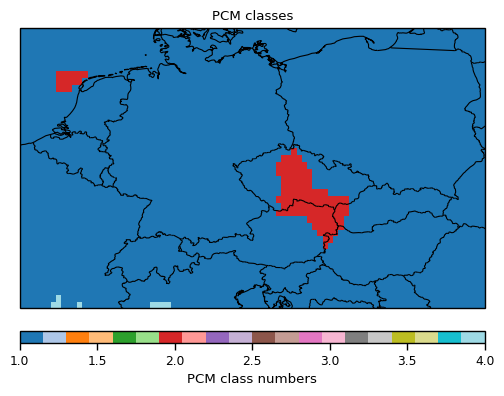

In [26]:
ds_plt = ds_europe_2023_monthly_neg['PCM_LABELS']

_, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={"projection": crs.Miller()},
)
ds_plt.plot(
    ax=ax,
    cmap="tab20",
    transform=crs.PlateCarree(),
    cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "aspect": 40, "label": "PCM class numbers"},
)
ax.coastlines()
ax.add_feature(feature.BORDERS)
ax.set_title("PCM classes")
plt.show()